# Practice 4. torch DNN classification

강아지와 고양이 이미지를 분류하는 Deep Neural Network 모델을 만들어 보세요. 활성화 함수를 sigmoid를 썼을 때와 ReLU를 썼을 때의 결과를 비교해보세요.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# zip 파일 압출 풀기

!unzip "/content/drive/MyDrive/multicampus/cats_and_dogs.zip" -d "/content"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/__MACOSX/cats_and_dogs/train/cats/._cat_1862.jpg  
  inflating: /content/cats_and_dogs/train/cats/cat_3913.jpg  
  inflating: /content/__MACOSX/cats_and_dogs/train/cats/._cat_3913.jpg  
  inflating: /content/cats_and_dogs/train/cats/cat_3907.jpg  
  inflating: /content/__MACOSX/cats_and_dogs/train/cats/._cat_3907.jpg  
  inflating: /content/cats_and_dogs/train/cats/cat_1876.jpg  
  inflating: /content/__MACOSX/cats_and_dogs/train/cats/._cat_1876.jpg  
  inflating: /content/cats_and_dogs/train/cats/cat_0598.jpg  
  inflating: /content/__MACOSX/cats_and_dogs/train/cats/._cat_0598.jpg  
  inflating: /content/cats_and_dogs/train/cats/cat_1686.jpg  
  inflating: /content/__MACOSX/cats_and_dogs/train/cats/._cat_1686.jpg  
  inflating: /content/cats_and_dogs/train/cats/cat_3091.jpg  
  inflating: /content/__MACOSX/cats_and_dogs/train/cats/._cat_3091.jpg  
  inflating: /content/cats_and_dogs/train/cats/cat_3085.jpg  
  inflating: /conte

## Dataset

### CustomDataset 정의

In [3]:
from torchvision.io import read_image
from torch.utils.data import Dataset

In [4]:
import pandas as pd

class CustomImageDataset(Dataset):
  def __init__(self, img_dir, transform=None):
    self.img_labels = pd.read_csv(f"{img_dir}/label.csv")
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = f"{self.img_dir}/{self.img_labels.iloc[idx, 0]}"
    img = read_image(img_path)
    # 이미지 가져올 때 transform 해서 가져오기
    if self.transform:
      img=self.transform(img)
    label = self.img_labels.iloc[idx, 1]
    return img, label

In [5]:
train_dataset = CustomImageDataset(img_dir="/content/cats_and_dogs/train")
test_dataset = CustomImageDataset(img_dir="/content/cats_and_dogs/test")

In [6]:
len(train_dataset), len(test_dataset)

(8000, 2000)

이미지 그려보기

In [ ]:
from matplotlib import pyplot as plt


def plot_img_tensor(img_tensor, cmap=None):
  img_array = img_tensor.numpy()              # tensor를 array 형태로 변환
  img_array = img_array.transpose(1, 2, 0)    # 이미지 시작점 변경
  plt.imshow(img_array, cmap=cmap)

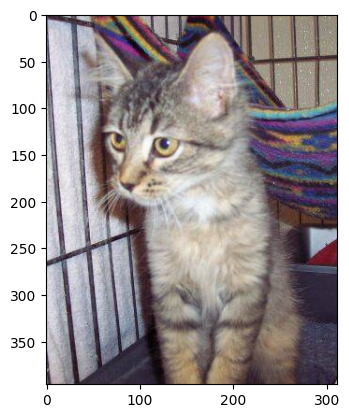

In [ ]:
plot_img_tensor(train_dataset[1][0])

이미지가 잘 나오는 것을 확인했다. 이제 모델에 맞춰 이미지 사이즈를 줄이고 변형시켜 데이터 양을 늘리는 작업을 할 것이다.

### transformdata & augmentation

- transform

- augmentation

### desired_size 변경 여기야!

In [165]:
import torch
from torchvision.transforms import RandomCrop, RandomRotation, RandomHorizontalFlip, transforms, Resize, ConvertImageDtype

desired_size = 256
transform = transforms.Compose([
    Resize(size=desired_size, antialias=True),
    RandomCrop(desired_size),           # desired_size에 맞게 랜덤하게 크롭
    RandomHorizontalFlip(),             # 랜덤하게 이미지 좌우 반전
    RandomRotation(degrees=(-45, 45)),  # degrees 범위 내에서 랜덤하게 이미지 회전
    ConvertImageDtype(torch.float)
])

In [166]:
# transform 적용

train_dataset = CustomImageDataset(
    img_dir="/content/cats_and_dogs/train",
    transform=transform
)
test_dataset = CustomImageDataset(
    img_dir="/content/cats_and_dogs/test",
    transform=transform
)

데이터 변형까지 완료했다. 이제 배치 사이즈에 맞춰 데이터를 가져오는 DataLoader를 생성해보겠다.

## DataLoader 생성

### batch size 변경 여기야!

In [167]:
from torch.utils.data import DataLoader

batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [168]:
image, label = next(iter(train_dataloader))
print(image.shape, label.shape)

torch.Size([256, 3, 256, 256]) torch.Size([256])


In [ ]:
next(iter(train_dataloader))

In [ ]:
# 시각화
def plot_batch(batch, label_dict, cmap=None):
  img_tensor = batch[0]
  labels = batch[1]

  fig, axes = plt.subplots(2, 4, figsize=(12, 6))
  for i, ax in enumerate(axes.flat):
    img = img_tensor[i].numpy()
    img = img.transpose(1, 2, 0)
    ax.imshow(img, cmap=cmap)
    ax.set_title(label_dict[labels[i].item()])

In [ ]:
batch = next(iter(train_dataloader))

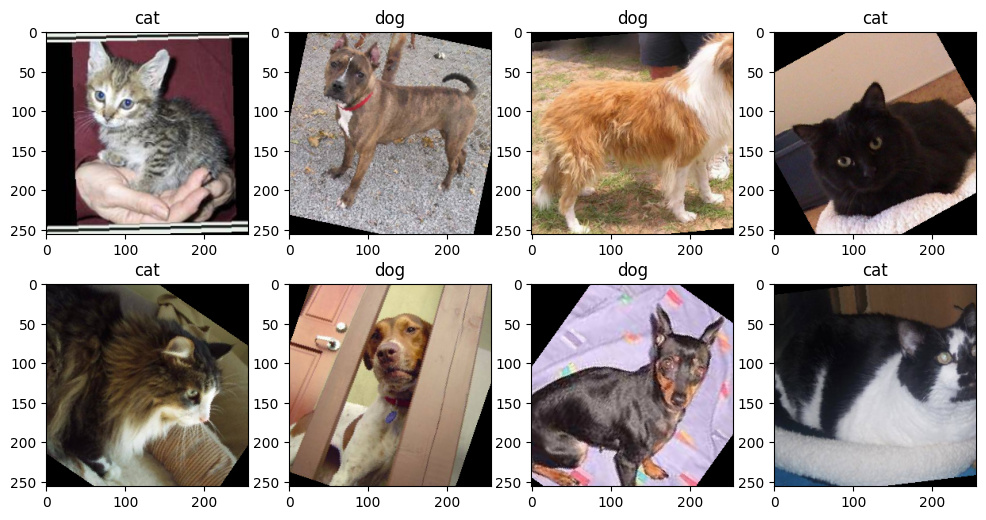

In [ ]:
plot_batch(batch, label_dict={0: "cat", 1: "dog"})

## CNN Classifier

### 모델 작성

간단한 CNN 모델 클래스를 만들어 보겠습니다.

### activation function이 ReLU 일때

In [177]:
import torch

class SimpleCNN(torch.nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding="same")
    print(self.conv1.weight.shape)
    self.conv2 = torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same")
    print(self.conv2.weight.shape)
    self.fc = torch.nn.Linear(in_features=65536, out_features=2)
    self.pool = torch.nn.MaxPool2d(2, 2)
    # self.activation = torch.nn.Sigmoid()
    self.activation = torch.nn.ReLU()

  def forward(self, x):
    x = self.pool(self.activation(self.conv1(x)))
    x = self.pool(self.activation(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [178]:
model = SimpleCNN()
# (out_channels, in_channels, kernel_height, kernel_width)

torch.Size([8, 3, 3, 3])
torch.Size([16, 8, 3, 3])


In [171]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [172]:
device

device(type='cpu')

In [179]:
model = model.to(device).float()

In [180]:
model.fc

Linear(in_features=65536, out_features=2, bias=True)

In [181]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             224
              ReLU-2          [-1, 8, 256, 256]               0
         MaxPool2d-3          [-1, 8, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           1,168
              ReLU-5         [-1, 16, 128, 128]               0
         MaxPool2d-6           [-1, 16, 64, 64]               0
            Linear-7                    [-1, 2]         131,074
Total params: 132,466
Trainable params: 132,466
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 13.50
Params size (MB): 0.51
Estimated Total Size (MB): 14.76
----------------------------------------------------------------


### 모델 학습

In [182]:
def get_mean(metrics):
    return round(sum(metrics) / len(metrics), 4)

In [183]:
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score


def train_model(model):
    model.train()
    loss_list = []
    acc_list = []
    for x_train, y_train in tqdm(train_dataloader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        outputs = model(x_train)
        loss = criterion(outputs, y_train)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = torch.argmax(outputs, dim=1)
        acc = ((y_train == pred).sum() / len(y_train)).item()
        acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [184]:
def validate_model(model):
    model.eval()
    loss_list = []
    acc_list = []
    for x_val, y_val in tqdm(test_dataloader):
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        with torch.no_grad():
            outputs = model(x_val)
            loss = criterion(outputs, y_val)
            loss_list.append(loss.item())

            pred = torch.argmax(outputs, dim=1)
            acc = ((y_val == pred).sum() / len(y_val)).item()
            acc_list.append(acc)
    return get_mean(loss_list), get_mean(acc_list)

In [185]:
from collections import defaultdict

def train_validate_model(model):
    logs = defaultdict(list)
    for epoch in range(epochs):
        train_loss, train_acc = train_model(model)
        val_loss, val_acc = validate_model(model)
        logs["train_loss"].append(train_loss)
        logs["train_acc"].append(train_acc)
        logs["val_loss"].append(val_loss)
        logs["val_acc"].append(val_acc)
        print(f"epoch {epoch + 1} train - loss: {train_loss} acc: {train_acc} val - loss: {val_loss} acc: {val_acc}")
    return logs

### 하이퍼 파라미터 셋팅

In [186]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10

In [187]:
logs = train_validate_model(model)

100%|██████████| 8/8 [00:53<00:00,  6.71s/it]


epoch 1 train - loss: 1.1335 acc: 0.5106 val - loss: 0.7111 acc: 0.5027


100%|██████████| 8/8 [00:53<00:00,  6.67s/it]


epoch 2 train - loss: 0.6883 acc: 0.5438 val - loss: 0.6774 acc: 0.598


100%|██████████| 8/8 [00:53<00:00,  6.72s/it]


epoch 3 train - loss: 0.6734 acc: 0.592 val - loss: 0.666 acc: 0.6227


100%|██████████| 8/8 [00:53<00:00,  6.72s/it]


epoch 4 train - loss: 0.6655 acc: 0.5991 val - loss: 0.6555 acc: 0.6299


100%|██████████| 8/8 [01:00<00:00,  7.53s/it]


epoch 5 train - loss: 0.6539 acc: 0.618 val - loss: 0.643 acc: 0.6377


100%|██████████| 8/8 [00:53<00:00,  6.73s/it]


epoch 6 train - loss: 0.6522 acc: 0.6208 val - loss: 0.6366 acc: 0.6523


100%|██████████| 8/8 [00:54<00:00,  6.76s/it]


epoch 7 train - loss: 0.6415 acc: 0.6316 val - loss: 0.6353 acc: 0.6569


100%|██████████| 8/8 [00:54<00:00,  6.79s/it]


epoch 8 train - loss: 0.6287 acc: 0.6479 val - loss: 0.6249 acc: 0.6648


100%|██████████| 8/8 [00:53<00:00,  6.71s/it]


epoch 9 train - loss: 0.6269 acc: 0.6499 val - loss: 0.6295 acc: 0.6613


100%|██████████| 8/8 [00:54<00:00,  6.82s/it]

epoch 10 train - loss: 0.6096 acc: 0.6722 val - loss: 0.627 acc: 0.6731


In [188]:
val_acc_mean = sum(logs["val_acc"]) / len(logs["val_acc"])
val_acc_mean

0.6299399999999999

In [189]:
from matplotlib import pyplot as plt

def plot_logs(logs):
    fig = plt.figure(figsize=(10, 4))

    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2)
    ax0.plot(logs["train_loss"], label="train")
    ax0.plot(logs["val_loss"], label="val")

    ax0.legend()
    ax0.set_title("loss")

    ax1.plot(logs["train_acc"], label="train")
    ax1.plot(logs["val_acc"], label="val")
    ax1.legend()
    ax1.set_title("accuracy")
    plt.legend()

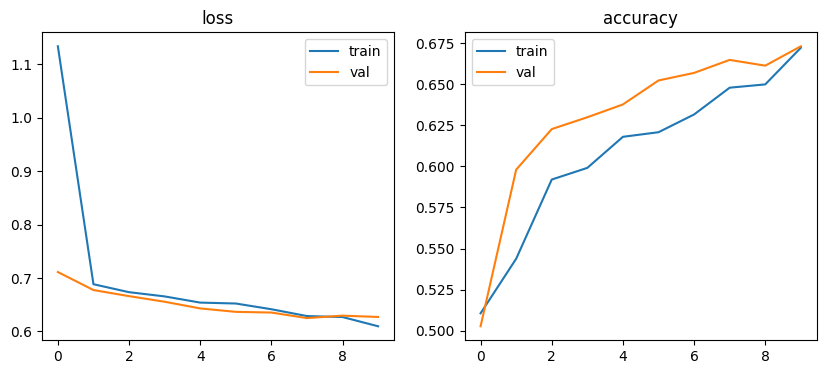

In [190]:
plot_logs(logs)